image 1/1 C:\Users\boped\Documents\GitHub\Bird-Recognition\dataset_parts\Carduelis_carduelis\235.jpg: 640x448 1 bird, 59.0ms


Speed: 2.7ms preprocess, 59.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


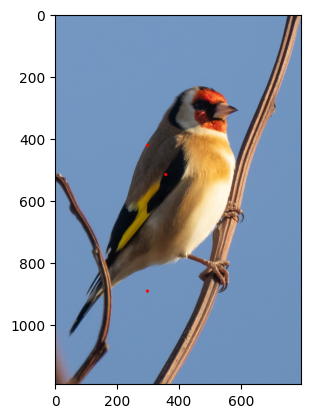

NameError: name 'sam' is not defined

In [19]:
from segment_anything import SamPredictor
import numpy as np
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. First detect the whole bird with YOLO
bird_detector = YOLO('yolov8n.pt')  # Pretrained on COCO (includes birds)
results = bird_detector(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")
x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()  # Bird bounding box

# 2. Calculate SMART points within the detected bird
bird_width = x2 - x1
bird_height = y2 - y1

input_points = np.array([
    [x1 + 0.5 * bird_width, y1 + 0.2 * bird_height],  # Head (center-top of bird)
    [x1 + 0.6 * bird_width, y1 + 0.3 * bird_height],  # Beak (right of head)
    [x1 + 0.5 * bird_width, y1 + 0.7 * bird_height]   # Wing (lower center)
])

# 3. Visualize the points (for debugging)
img = cv2.imread(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")
for point in input_points:
    cv2.circle(img, tuple(point.astype(int)), 5, (0,0,255), -1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. Run SAM with these dynamic points
predictor = SamPredictor(sam)
predictor.set_image(img)
masks, scores, _ = predictor.predict(
    point_coords=input_points,
    point_labels=np.array([1, 1, 1]),  # 1=foreground
    multimask_output=False
)

print(scores)

# Only accept if confidence is high enough
if scores[0] > confidence_threshold:  # Adjust threshold as needed
    detected_parts[part_name] = masks[0]

# 5. Save the best mask for each part
for i, mask in enumerate(masks):
    cv2.imwrite(f"part_{['head','beak','wing'][i]}.png", mask * 255)

In [ ]:
# 2. Imports and model initialization
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Download from https://github.com/facebookresearch/segment-anything#model-checkpoints
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt')  # Auto-downloads pretrained weights

# 3. Detection function with visualization
def detect_bird_parts(img_path):
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("No birds detected!")
        return
    
    # Get largest bird detection
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    
    parts = {
        'head': [x1 + 0.5*(x2-x1), y1 + 0.2*(y2-y1)],
        'beak': [x1 + 0.6*(x2-x1), y1 + 0.3*(y2-y1)], 
        'wing': [x1 + 0.5*(x2-x1), y1 + 0.7*(y2-y1)]
    }
    
    # Visualize points
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.scatter(parts[:,0], parts[:,1], c='red', s=100, marker='o')
    plt.title("SAM Input Points")
    plt.axis('off')
    plt.show()
    
    # Run SAM
    predictor.set_image(img_rgb)
    
    detected_parts = {}
        
    for part_name, point in parts.items():            
        masks, scores, _ = predictor.predict(
            point_coords=parts,
            point_labels=np.array([1, 1, 1]),  # 1=foreground
            multimask_output=False
        )
        
        print(scores)
        
        
        
        # Only accept if confidence is high enough
        if scores[0] > 0.3:  # Adjust threshold as needed
            detected_parts[part_name] = masks[0]
    
    # Display results
    plt.figure(figsize=(15, 5))
    for i, detected_parts in enumerate(detected_parts):
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        show_mask(mask, plt.gca())
        plt.title(f"{['Head','Beak','Wing'][i]}\nScore: {score:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Helper function to overlay masks
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# 4. Run detection
detect_bird_parts(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")# 2. Imports and model initialization


0: 640x448 2 birds, 222.4ms
Speed: 6.3ms preprocess, 222.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


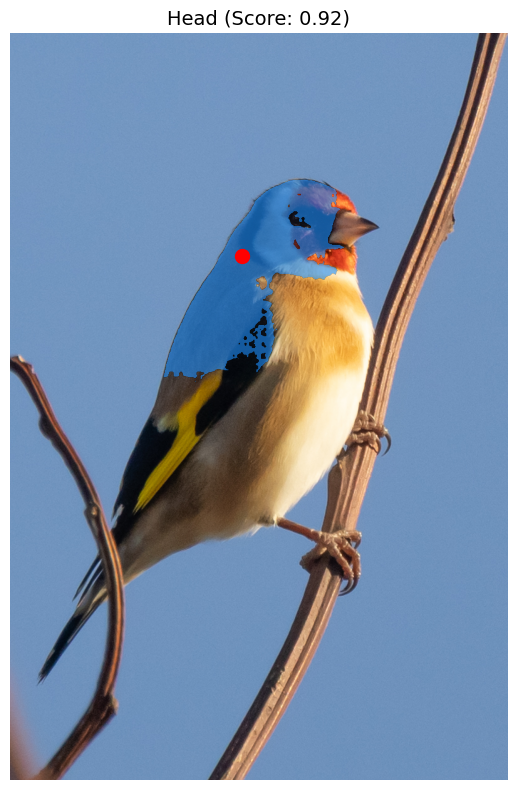

Head detection score: 0.92


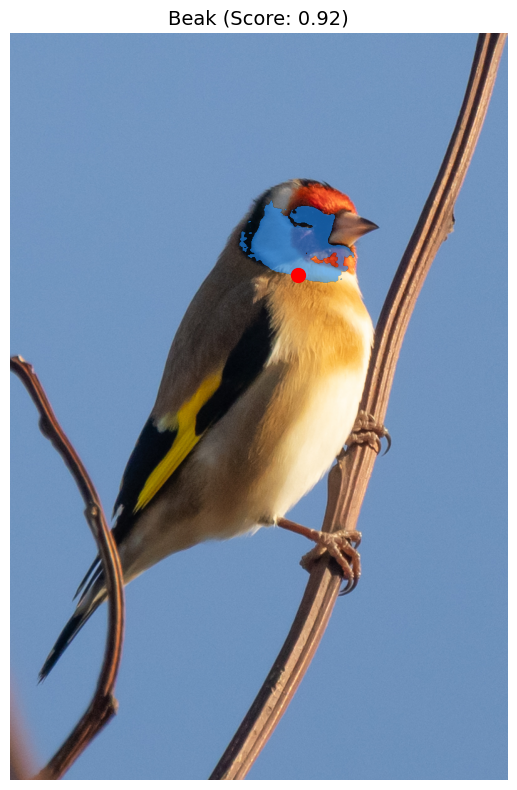

Beak detection score: 0.92


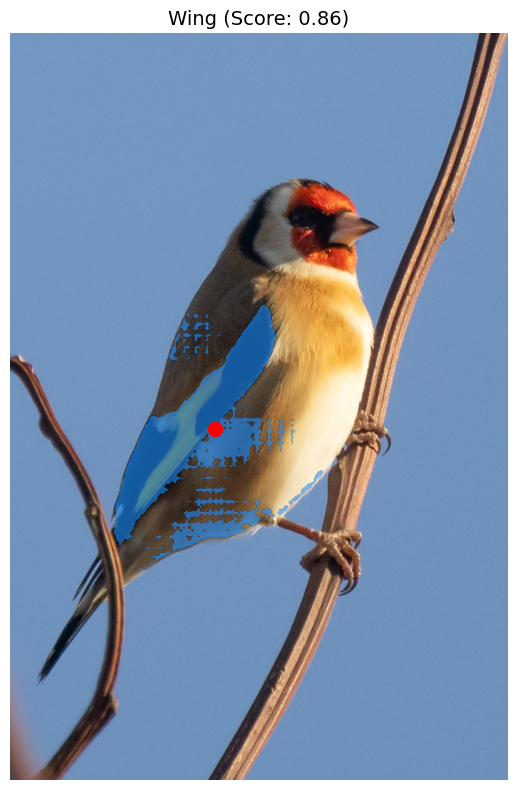

Wing detection score: 0.86


In [5]:

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)  # Auto-downloads pretrained weights

# Helper function to overlay masks
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def detect_bird_parts(img_path, confidence_threshold=0.7):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("No birds detected!")
        return
    
    # Get largest bird detection
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    bird_width = x2 - x1
    bird_height = y2 - y1
    
    # Define part locations with spatial constraints
    parts_config = {
        'head': {
            'rel_pos': [0.5, 0.2],
            'size_factor': 0.3,
            'negative_points': [[0.5, 0.6]]  # Avoid body
        },
        'beak': {
            'rel_pos': [0.7, 0.25],
            'size_factor': 0.15,
            'negative_points': [[0.4, 0.3]]  # Avoid head
        },
        'wing': {
            'rel_pos': [0.4, 0.65],
            'size_factor': 0.4,
            'negative_points': [[0.5, 0.3]]  # Avoid head
        }
    }
    
    # Process each part
    predictor.set_image(img_rgb)
    detected_parts = {}
    
    for part_name, config in parts_config.items():
        # Calculate absolute coordinates
        abs_x = x1 + config['rel_pos'][0] * bird_width
        abs_y = y1 + config['rel_pos'][1] * bird_height
        point = np.array([[abs_x, abs_y]])
        
        # Create negative points (background)
        neg_points = np.array([
            [x1 + p[0] * bird_width, y1 + p[1] * bird_height]
            for p in config['negative_points']
        ]) if config['negative_points'] else None
        
        # Combine all points
        all_points = point
        all_labels = np.array([1])  # 1=foreground
        
        if neg_points is not None:
            all_points = np.concatenate([all_points, neg_points])
            all_labels = np.concatenate([all_labels, np.zeros(len(neg_points))])
        
        # Get masks with spatial constraints
        masks, scores, _ = predictor.predict(
            point_coords=all_points,
            point_labels=all_labels,
            multimask_output=True,
            box=np.array([
                max(0, abs_x - bird_width * config['size_factor']),
                max(0, abs_y - bird_height * config['size_factor']),
                min(width, abs_x + bird_width * config['size_factor']),
                min(height, abs_y + bird_height * config['size_factor'])
            ]) if config['size_factor'] else None
        )
        
        # Store best mask if above threshold
        best_idx = np.argmax(scores)
        if scores[best_idx] > confidence_threshold:
            detected_parts[part_name] = {
                'mask': masks[best_idx],
                'score': scores[best_idx],
                'point': point[0]
            }
    
    # Display each detected part individually
    for part_name, result in detected_parts.items():
        plt.figure(figsize=(8, 8))
        
        # Show original image with mask overlay
        plt.imshow(img_rgb)
        show_mask(result['mask'], plt.gca())
        plt.scatter(result['point'][0], result['point'][1], c='red', s=100)
        
        # Add title with score
        plt.title(f"{part_name.capitalize()} (Score: {result['score']:.2f})", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print score in console
        print(f"{part_name.capitalize()} detection score: {result['score']:.2f}")
    
    # If no parts detected
    if not detected_parts:
        print("No parts detected above confidence threshold!")
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.title("No parts detected", fontsize=14)
        plt.axis('off')
        plt.show()

# 4. Run detection
detect_bird_parts(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 162.9ms
Speed: 7.1ms preprocess, 162.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


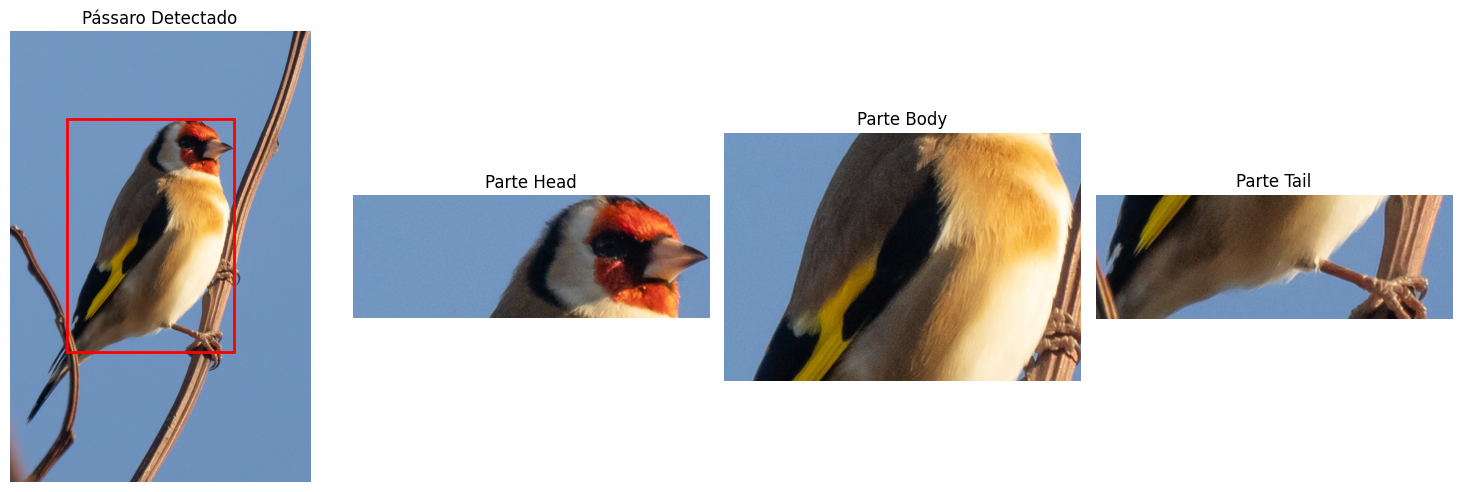

In [6]:
def detect_and_divide_bird(img_path, show_grid=True):
    # Carregar imagem
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erro: Não foi possível ler a imagem {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detectar pássaro com YOLO
    results = bird_detector(img_rgb)
    if len(results[0].boxes) == 0:
        print("Nenhum pássaro detectado!")
        return
    
    # Obter a maior detecção
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy()
    
    # Dividir a região do pássaro em 3 partes verticais
    height = y2 - y1
    section_height = height / 3
    
    # Divisão com proporções variáveis (ex: 25%-50%-25%)
    sections = {
        'head': (x1, y1, x2, y1 + 0.25*(y2-y1)),
        'body': (x1, y1 + 0.25*(y2-y1), x2, y1 + 0.75*(y2-y1)),
        'tail': (x1, y1 + 0.75*(y2-y1), x2, y2)
    }
    
    # Mostrar resultados
    plt.figure(figsize=(15, 5))
    
    # Imagem original com bounding box
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                         fill=False, edgecolor='red', linewidth=2))
    plt.title("Pássaro Detectado")
    plt.axis('off')
    
    # Mostrar cada seção individualmente
    for i, (name, (sx1, sy1, sx2, sy2)) in enumerate(sections.items()):
        plt.subplot(1, 4, i+2)
        section = img_rgb[int(sy1):int(sy2), int(sx1):int(sx2)]
        plt.imshow(section)
        
        if show_grid:
            # Adicionar grid para visualização
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.grid(color='white', linestyle='-', linewidth=0.5)
            plt.gca().set_xticks(np.arange(-0.5, section.shape[1], 1), minor=True)
            plt.gca().set_yticks(np.arange(-0.5, section.shape[0], 1), minor=True)
        
        plt.title(f"Parte {name.capitalize()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Exemplo de uso
detect_and_divide_bird(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 74.8ms
Speed: 2.7ms preprocess, 74.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


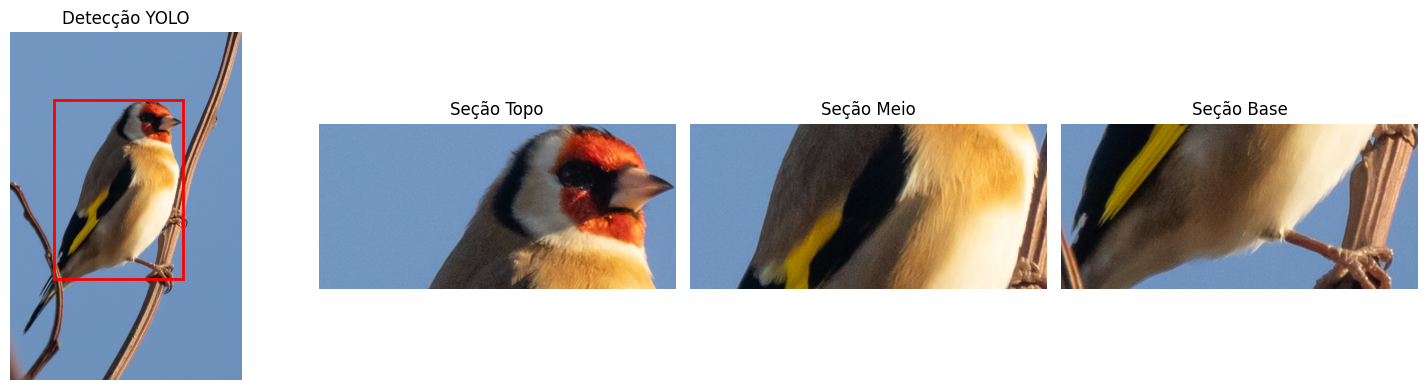

In [8]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Inicialização do YOLO (uma única vez)
bird_detector = YOLO('yolov8n.pt')  # Modelo pré-treinado que já inclui aves

def divide_bird_sections(img_path):
    # 2. Detecção do pássaro (YOLO)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = bird_detector(img_rgb)
    
    if not results[0].boxes:
        print("⚠️ Nenhum pássaro detectado!")
        return

    # 3. Obter coordenadas da caixa delimitadora
    x1, y1, x2, y2 = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
    
    # 4. Divisão em 3 seções verticais iguais
    height = y2 - y1
    sections = {
        'Topo':    (x1, y1,             x2, y1 + int(height/3)),
        'Meio':    (x1, y1 + int(height/3), x2, y1 + int(2*height/3)),
        'Base':    (x1, y1 + int(2*height/3), x2, y2)
    }

    # 5. Visualização
    plt.figure(figsize=(15, 4))
    
    # Imagem original com bounding box
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                         fill=False, edgecolor='red', linewidth=2))
    plt.title("Detecção YOLO")
    plt.axis('off')

    # Mostrar cada seção
    for i, (name, (sx1, sy1, sx2, sy2)) in enumerate(sections.items()):
        plt.subplot(1, 4, i+2)
        section = img_rgb[sy1:sy2, sx1:sx2]
        plt.imshow(section)
        plt.title(f"Seção {name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Exemplo de uso
divide_bird_sections(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")


0: 640x448 2 birds, 967.0ms
Speed: 3.7ms preprocess, 967.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


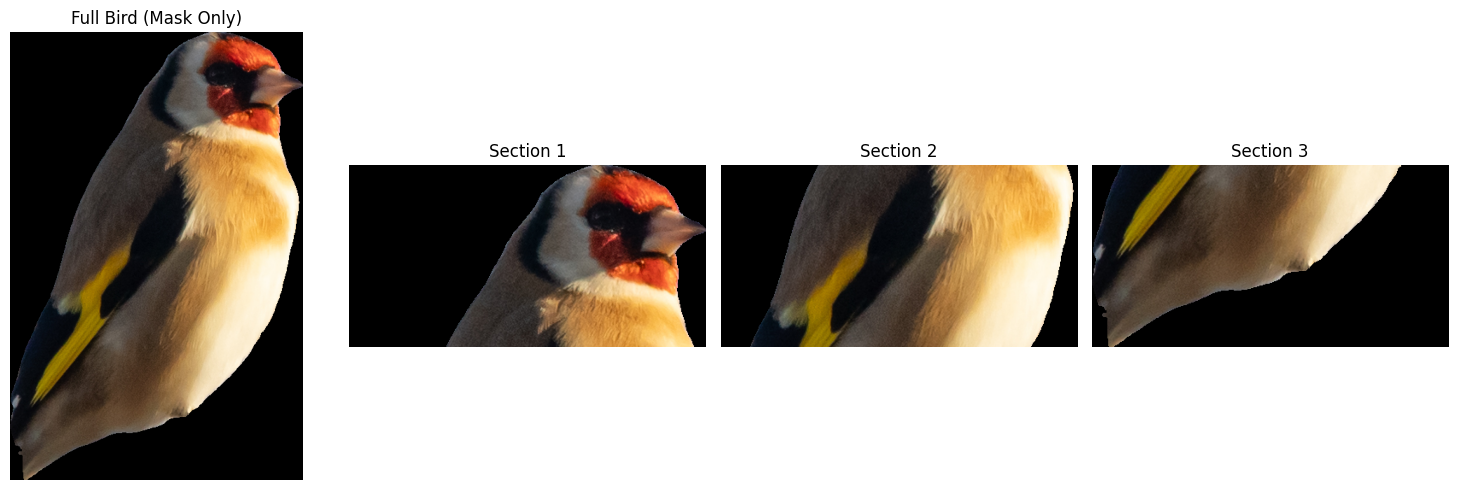

In [15]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Initialize models
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
bird_detector = YOLO('yolov8n.pt').to(device)

def divide_bird_only(img_path):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect bird with YOLO
    results = bird_detector(img_rgb)
    if not results[0].boxes:
        print("No bird detected!")
        return
    
    # Get precise bird mask using SAM
    x1, y1, x2, y2 = map(int, results[0].boxes.xyxy[0].cpu().numpy())
    predictor.set_image(img_rgb)
    masks, _, _ = predictor.predict(
        box=np.array([x1, y1, x2, y2]),
        multimask_output=False
    )
    bird_mask = masks[0]
    
    # Get only bird pixels (remove background)
    isolated_bird = np.zeros_like(img_rgb)
    isolated_bird[bird_mask] = img_rgb[bird_mask]
    
    # Find bird boundaries in mask
    y_coords, x_coords = np.where(bird_mask)
    y_min, y_max = y_coords.min(), y_coords.max()
    x_min, x_max = x_coords.min(), x_coords.max()
    bird_height = y_max - y_min
    
    # Divide into 3 vertical sections using MASK coordinates
    section_height = bird_height // 3
    sections = []
    
    for i in range(3):
        # Create section mask
        section_mask = np.zeros_like(bird_mask)
        y_start = y_min + i * section_height
        y_end = y_min + (i+1) * section_height
        section_mask[y_start:y_end, x_min:x_max] = bird_mask[y_start:y_end, x_min:x_max]
        
        # Apply mask and crop
        section = np.zeros_like(img_rgb)
        section[section_mask] = img_rgb[section_mask]
        section = section[y_start:y_end, x_min:x_max]
        sections.append(section)
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    # Full isolated bird
    plt.subplot(1, 4, 1)
    plt.imshow(isolated_bird[y_min:y_max, x_min:x_max])
    plt.title("Full Bird (Mask Only)")
    plt.axis('off')
    
    # Show each section
    for i, section in enumerate(sections):
        plt.subplot(1, 4, i+2)
        plt.imshow(section)
        plt.title(f"Section {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
divide_bird_only(".\\dataset_parts\\Carduelis_carduelis\\235.jpg")